# Survival Analysis

`Survival Analysis` is a collection of statistical methods used to examine and predict the time until an event of interest occurs. This form of analysis originated in Healthcare, with a focus on time-to-death. Since then, Survival Analysis has been successfully applied to use cases in virtually every industry around the globe.


Telco Use Case Examples:

1. `Customer Retention`: It is widely accepted that the cost of retention is lower than the cost of acquisition. With the event of interest being a service cancellation, Telco companies can more effectively manage churn by using Survival Analysis to better predict at what point in time specific customers are likely to be in risk.

2. `Hardware Failures`: The quality of experience a customer has with your products and services plays a key role in the decision to renew or cancel. The network itself is at the epicenter of this experience. With time to failure as the event of interest, Survival Analysis can be used to predict when hardware will need to be repaired or replaced.

3. `Device and Data Plan Upgrades`: There are key moments in a customer's lifecycle when changes to their plan take place. With the event of interest being a plan change, Survival Analysis can be used to predict when such a change will take place and then actions can be taken to positively influence the selected products or services.


We will apply and review several techniques that are commonly used for Survival Analysis:

1. Kaplan-Meier & the Log-Rank Test
2. Cox Proportional Hazards
3. Accelerated Failure Time

In [1]:
import pandas as pd

#### Download the data

In [2]:
! wget https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

--2022-08-02 18:49:22--  https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970457 (948K) [text/plain]
Saving to: ‘Telco-Customer-Churn.csv.2’

Telco-Customer-Chur 100%[===================>] 947.71K  --.-KB/s    in 0.005s  

2022-08-02 18:49:22 (176 MB/s) - ‘Telco-Customer-Churn.csv.2’ saved [970457/970457]



### EDA

In [3]:
df = pd.read_csv('/content/Telco-Customer-Churn.csv')
print('Data Shape : ', df.shape)
df.head()

Data Shape :  (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print('Number of Unique customers : ', df['customerID'].nunique())

Number of Unique customers :  7043


Total customers churned

In [5]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

Gender vs Churn

In [6]:
pd.crosstab(df['gender'], df['Churn'])

Churn,No,Yes
gender,,
Female,2549,939
Male,2625,930


Looks well balanced!

Do senior citizens have a higher tendency to churn?

In [7]:
pd.crosstab(df['SeniorCitizen'], df['Churn'])

Churn,No,Yes
SeniorCitizen,,
0,4508,1393
1,666,476


Senior citizens have ~40% chance of churning, it's only 25% otherwise!

Relationship between churn and total amount paid by the customer

In [8]:
# Clean Total Charges field and convert to numeric data type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', 0))

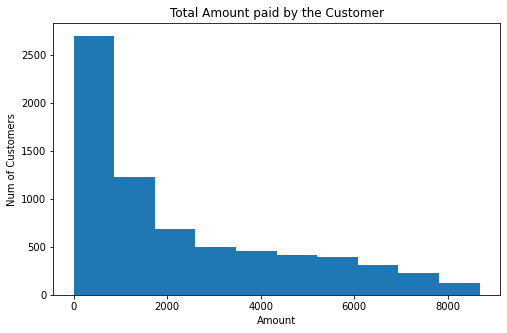

In [13]:
import matplotlib.pyplot as plt
df['TotalCharges'].plot(kind='hist', bins=10,\
                        title='Total Amount paid by the Customer',\
                        xlabel='Amount',ylabel='Customers',\
                        figsize=(8,5))
plt.xlabel("Amount")
plt.ylabel("Num of Customers")
plt.show()

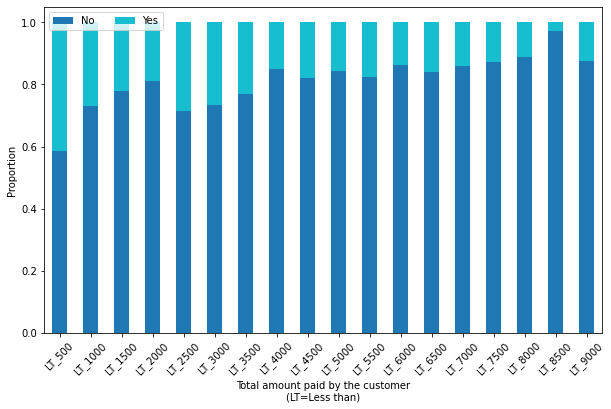

In [12]:
min_amt, max_amt = 0, 10000

bins = [i for i in range(min_amt, max_amt, 500)]

# Taking Bin range to Bin label. Also, remove first element. 
# UpperLimit_0 is not meaning-ful (also, num(bins) must be = num(labels) + 1)
labels = [f'LT_{i}' for i in bins[1:]]

df['TotalChargesBucket'] = pd.cut(df['TotalCharges'], bins=bins, labels=labels)

# Generate the cross-tab with normalized values
cross_tab_prop = pd.crosstab(index=df['TotalChargesBucket'],
                             columns=df['Churn'],
                             normalize="index")

# Plot the data
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6),
                    rot=45)

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Total amount paid by the customer\n(LT=Less than)")
plt.ylabel("Proportion")
plt.show()

Customer paying higher amounts are less prone to churn, which matches the intuition. 

There can be multiple reasons for churn in the bucket - LessThan_500 : 

1. New Customers
2. Better offers from competitors
3. Less dependency (or services) on the company, and hence easier to switch

Is month-to-month contract responsible for higher churn rate?

In [14]:
pd.crosstab(df['Contract'], df['Churn'])

Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


It is indeed the case!

42% churn rate in monthly contract, compared to 11% in One-year and just 2% in Two-year contracts. This again justifies the intuition. 